In [47]:
import utils
import sys
if 'utils' in sys.modules:
    del sys.modules['utils']
import utils
import torch
from tqdm import tqdm
from torchvision import datasets, transforms
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import nbformat
import os
import collections
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns

checkpoint_path = 'weights/checkpoint_28x28.pth'
RESUME_TRAINING = False

PRINT_IMG = True
AUGMENT_DATASET = False
AUGMENT_FRACTION = 0.3
TRANSFORM_DATASET = False

COSINE_ANNEALING = True
STEPLR = False
REDUCE_ON_PLATEAU = False

OPTIMIZER='SGD'

### Hyperparameters ###
BATCH_SIZE = 128
LEARNING_RATE = 0.01
MOMENTUM = 0.9
EPOCHS = 20

WEIGHT_DECAY = 0

### Early Stopping ###
EARLY_STOPPING = True
ES_PATIENCE = 3

SEED = 0

random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [48]:
train_dataset, train_dataset_raw = utils.create_train_dataset(TRANSFORM_DATASET, AUGMENT_DATASET, AUGMENT_FRACTION, 28)
test_dataset, validation_dataset, test_dataset_raw = utils.create_test_dataset(validation_split=0.3, img_size=28)

Dimensione del dataset originale: 60000
Dimensione del dataset trasformato: 60000
Dimensione del sottoinsieme aumentato: 18000


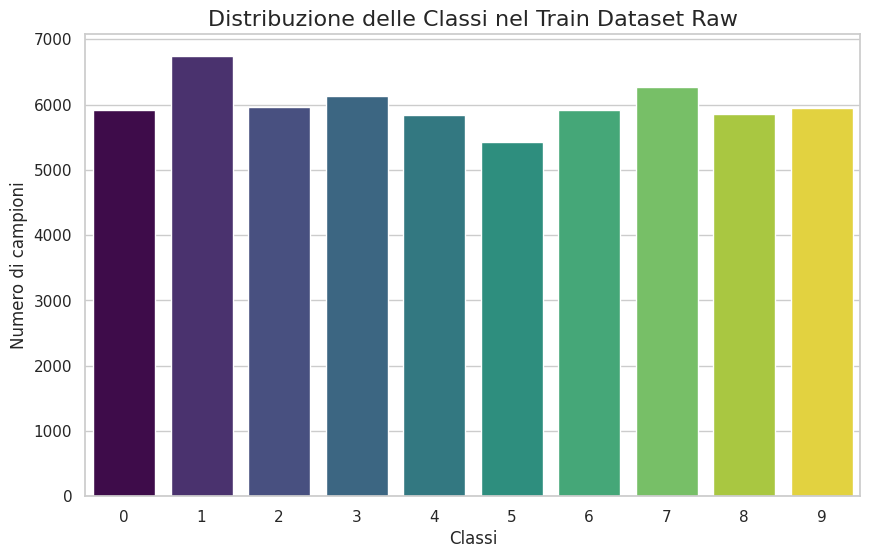

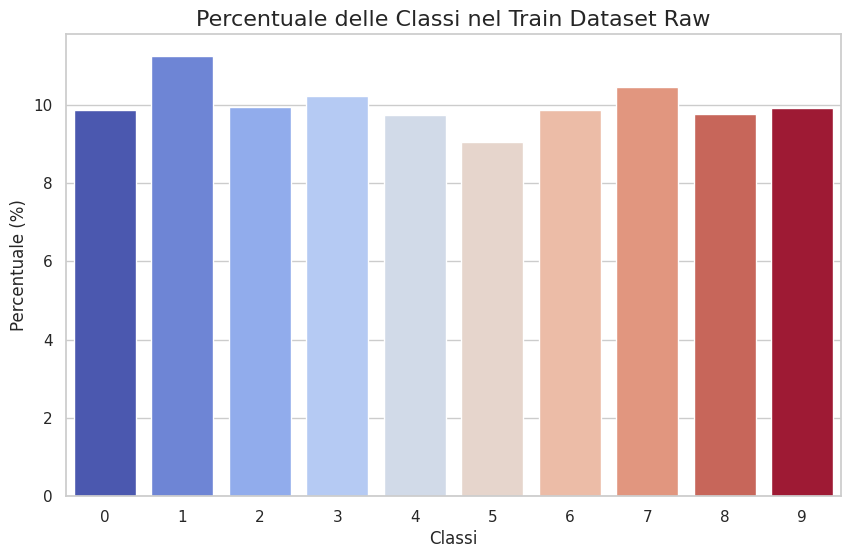

In [49]:
utils.plot_dataset_raw_statistics(train_dataset_raw, "Train Dataset Raw")

Numero totale di campioni: 60000
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 20000, 1: 20000, 2: 20000}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 28, 28])}
Relazione 0: 20000 campioni (33.33%)
Relazione 1: 20000 campioni (33.33%)
Relazione 2: 20000 campioni (33.33%)




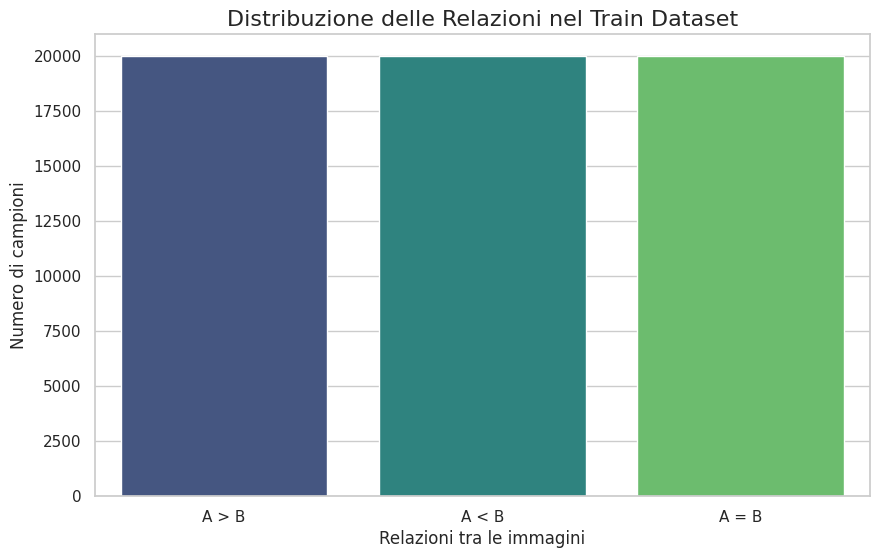

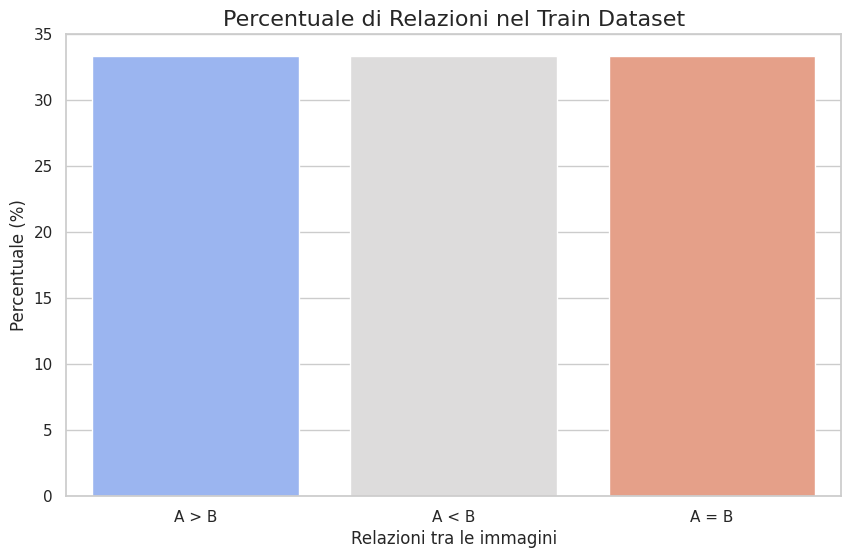

In [50]:
utils.plot_dataset_statistics(train_dataset, dataset_name="Train Dataset")

Numero totale di campioni: 7000
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 2348, 2: 2329, 1: 2323}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 28, 28])}
Relazione 0: 2348 campioni (33.54%)
Relazione 2: 2329 campioni (33.27%)
Relazione 1: 2323 campioni (33.19%)




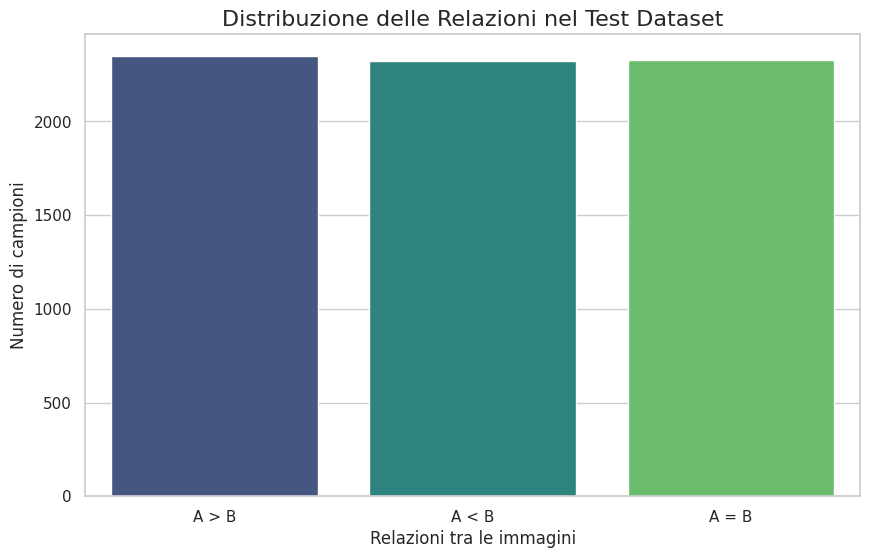

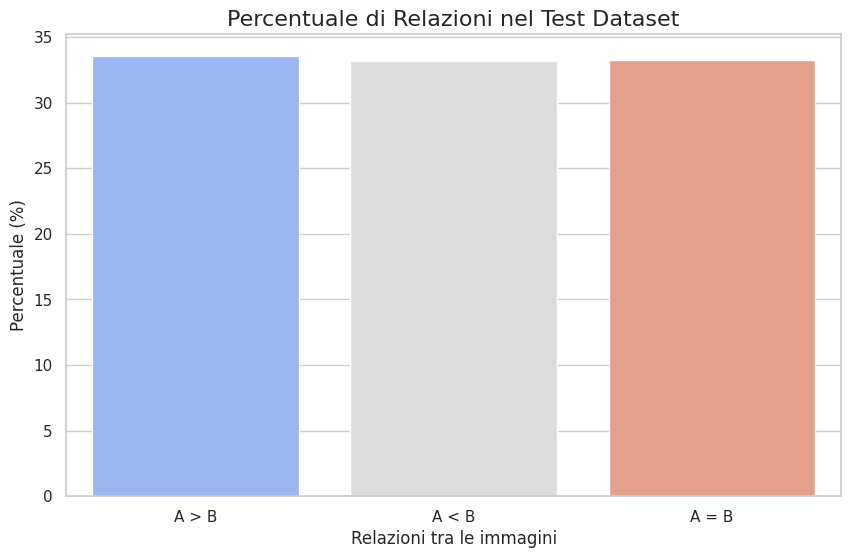

In [51]:
utils.plot_dataset_statistics(test_dataset, dataset_name="Test Dataset")

Numero totale di campioni: 2999
Distribuzione delle relazioni (A > B, A < B, A = B): {2: 1004, 0: 985, 1: 1010}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 28, 28])}
Relazione 2: 1004 campioni (33.48%)
Relazione 0: 985 campioni (32.84%)
Relazione 1: 1010 campioni (33.68%)




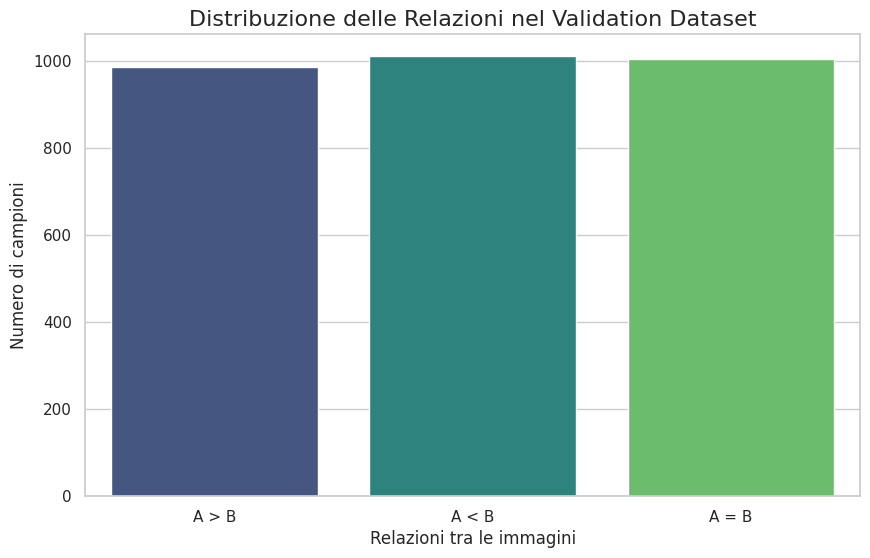

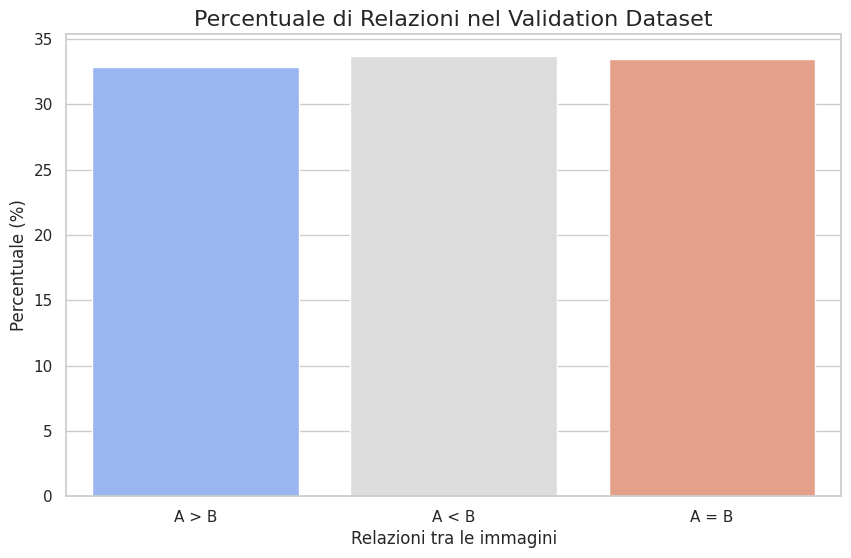

In [52]:
utils.plot_dataset_statistics(validation_dataset, dataset_name="Validation Dataset")

In [53]:
train_loader, validation_loader, test_loader = utils.create_data_loader(train_dataset, validation_dataset, test_dataset, BATCH_SIZE)

In [54]:
print("Size train_loader: ", len(train_loader), " Size train_dataset: ", len(train_dataset))
print("Size validation_loader: ", len(validation_loader), " Size validation_dataset: ", len(validation_dataset))
print("Size test_loader: ", len(test_loader), " Size test_dataset: ", len(test_dataset))

Size train_loader:  469  Size train_dataset:  60000
Size validation_loader:  24  Size validation_dataset:  2999
Size test_loader:  55  Size test_dataset:  7000


In [55]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [56]:
import torch.nn as nn
import torch.nn.functional as F

class CustomLeNet5(nn.Module):
    def __init__(self):
        super(CustomLeNet5, self).__init__()
        self.conv1 = nn.Conv2d(2, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CustomLeNet5()
print(model)


CustomLeNet5(
  (conv1): Conv2d(2, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)


In [57]:
# define Loss and Optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
if OPTIMIZER == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
elif OPTIMIZER == 'ADAM':
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

if REDUCE_ON_PLATEAU:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
elif COSINE_ANNEALING:
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
elif STEPLR:
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7, verbose=True)

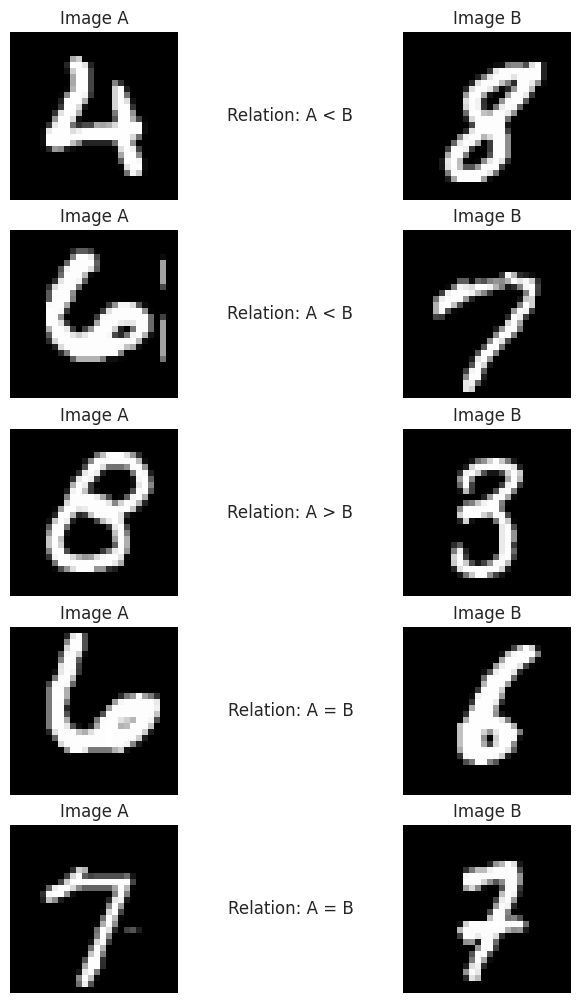

In [58]:
from torch.utils.tensorboard import SummaryWriter

if OPTIMIZER == 'SGD':
    fileName = f"runs/log28x28_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_m={MOMENTUM}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"
elif OPTIMIZER == 'ADAM':
    fileName = f"runs/log28x28_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"

writer = SummaryWriter(fileName)

writer.add_graph(model, next(iter(train_loader))[0])

writer.add_figure('Image_pair', utils.show_dataset(train_loader, 5))

In [59]:
# define train and test functions
from tqdm import tqdm

def train(train_data_loader, model):
    print('Training')
    train_itr = 0
    correct_train = 0
    total_train = 0
    running_loss = 0.0
    train_loss_list = []
    train_accuracy_list = []
    
    # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value

        train_loss_list.append(loss_value)
        train_accuracy_list.append(100 * correct_train / total_train)

        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return running_loss / len(train_data_loader), 100 * correct_train / total_train, train_loss_list, train_accuracy_list

def validate(data_loader, model):
    print('Validating')
    val_itr = 0
    correct = 0
    total = 0
    running_loss = 0.0
    val_loss_list = []
    val_accuracy_list = []
    
    # initialize tqdm progress bar
    prog_bar = tqdm(data_loader, total=len(data_loader))
    
    for i, data in enumerate(prog_bar):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        with torch.no_grad():
            outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss_value = loss.item()
        running_loss += loss_value
        val_loss_list.append(loss_value)
        val_accuracy_list.append(100 * correct / total)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return loss_value, 100 * correct / total, val_loss_list, val_accuracy_list

In [60]:
# TRAIN!!!
start_epoch = 0
if RESUME_TRAINING and os.path.exists(checkpoint_path):
    start_epoch, best_val_loss, patience_counter = utils.load_checkpoint(model, optimizer, scheduler, checkpoint_path)

model.train()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
total_val_loss = []
total_val_acc = []
total_train_loss = []
total_train_acc = []
lr_history = []
best_val_loss = float('inf')
for epoch in range(EPOCHS):
        print(f"\nEPOCH {epoch+1} of {EPOCHS}")

        # start timer and carry out training and validation
        start = time.time()
        train_loss, train_acc, train_loss_list, train_acc_list = train(train_loader, model)
        val_loss, val_acc, val_loss_list, val_acc_list = validate(validation_loader, model)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        total_train_loss.extend(train_loss_list)
        total_train_acc.extend(train_acc_list)
        total_val_loss.extend(val_loss_list)
        total_val_acc.extend(val_acc_list)

        if REDUCE_ON_PLATEAU:
                scheduler.step(val_loss)
        else:
                scheduler.step()

        lr_history.append(optimizer.param_groups[0]['lr'])

        print(f"Epoch #{epoch+1} train loss: {train_loss:.3f} train accuracy: {train_acc:.2f}")   
        print(f"Epoch #{epoch+1} validation loss: {val_loss:.3f} validation accuracy: {val_acc:.2f}")   
        end = time.time()
        print("Learning rate actual: ", optimizer.param_groups[0]['lr'])
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")
        writer.add_scalars('Loss', {
                'Train': train_loss,
                'Validation': val_loss
        }, epoch + 1)
        
        writer.add_scalars('Accuracy', {
                'Train': train_acc,
                'Validation': val_acc
        }, epoch + 1)

        if EARLY_STOPPING:
                if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        patience_counter = 0
                        best_model_state = model.state_dict()
                else:
                        patience_counter += 1
                        print(f"No improvement for {patience_counter} epoch(s).")
                if patience_counter >= ES_PATIENCE:
                        print(f"Early stopping triggered after {epoch+1} epochs.")
                        utils.save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, patience_counter, checkpoint_path)
                        break

        utils.save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, patience_counter, checkpoint_path)

if EARLY_STOPPING and 'best_model_state' in locals():
    model.load_state_dict(best_model_state)

# Valida il modello appena trainato con il test set
model.eval()
test_loss, test_acc, _, _ = validate(test_loader, model)
print(f"Test loss: {test_loss:.3f} Test accuracy: {test_acc:.2f}")
writer.add_scalar('Test Loss', test_loss)
writer.add_scalar('Test Accuracy', test_acc)



EPOCH 1 of 20
Training


Loss: 0.5313: 100%|██████████| 469/469 [00:08<00:00, 53.61it/s]


Validating


Loss: 0.6315: 100%|██████████| 24/24 [00:00<00:00, 117.42it/s]


Epoch #1 train loss: 0.811 train accuracy: 62.99
Epoch #1 validation loss: 0.632 validation accuracy: 76.06
Learning rate actual:  0.009972609476841367
Took 0.149 minutes for epoch 1
Checkpoint saved at epoch 1.

EPOCH 2 of 20
Training


Loss: 0.4715: 100%|██████████| 469/469 [00:08<00:00, 53.92it/s]


Validating


Loss: 0.5452: 100%|██████████| 24/24 [00:00<00:00, 116.57it/s]


Epoch #2 train loss: 0.457 train accuracy: 81.80
Epoch #2 validation loss: 0.545 validation accuracy: 83.36
Learning rate actual:  0.009890738003669028
Took 0.148 minutes for epoch 2
Checkpoint saved at epoch 2.

EPOCH 3 of 20
Training


Loss: 0.3477: 100%|██████████| 469/469 [00:08<00:00, 55.49it/s]


Validating


Loss: 0.4065: 100%|██████████| 24/24 [00:00<00:00, 118.53it/s]


Epoch #3 train loss: 0.326 train accuracy: 87.55
Epoch #3 validation loss: 0.406 validation accuracy: 88.66
Learning rate actual:  0.009755282581475769
Took 0.144 minutes for epoch 3
Checkpoint saved at epoch 3.

EPOCH 4 of 20
Training


Loss: 0.1766: 100%|██████████| 469/469 [00:08<00:00, 54.02it/s]


Validating


Loss: 0.4575: 100%|██████████| 24/24 [00:00<00:00, 93.23it/s]


Epoch #4 train loss: 0.253 train accuracy: 90.65
Epoch #4 validation loss: 0.458 validation accuracy: 89.96
Learning rate actual:  0.009567727288213004
Took 0.149 minutes for epoch 4
No improvement for 1 epoch(s).
Checkpoint saved at epoch 4.

EPOCH 5 of 20
Training


Loss: 0.1801: 100%|██████████| 469/469 [00:11<00:00, 42.38it/s]


Validating


Loss: 0.4403: 100%|██████████| 24/24 [00:00<00:00, 94.08it/s]


Epoch #5 train loss: 0.207 train accuracy: 92.33
Epoch #5 validation loss: 0.440 validation accuracy: 91.66
Learning rate actual:  0.009330127018922194
Took 0.189 minutes for epoch 5
No improvement for 2 epoch(s).
Checkpoint saved at epoch 5.

EPOCH 6 of 20
Training


Loss: 0.1070: 100%|██████████| 469/469 [00:10<00:00, 45.73it/s]


Validating


Loss: 0.4142: 100%|██████████| 24/24 [00:00<00:00, 90.03it/s]


Epoch #6 train loss: 0.173 train accuracy: 93.65
Epoch #6 validation loss: 0.414 validation accuracy: 91.43
Learning rate actual:  0.009045084971874737
Took 0.176 minutes for epoch 6
No improvement for 3 epoch(s).
Early stopping triggered after 6 epochs.
Checkpoint saved at epoch 6.
Validating


Loss: 0.1082: 100%|██████████| 55/55 [00:00<00:00, 92.62it/s]

Test loss: 0.108 Test accuracy: 92.29


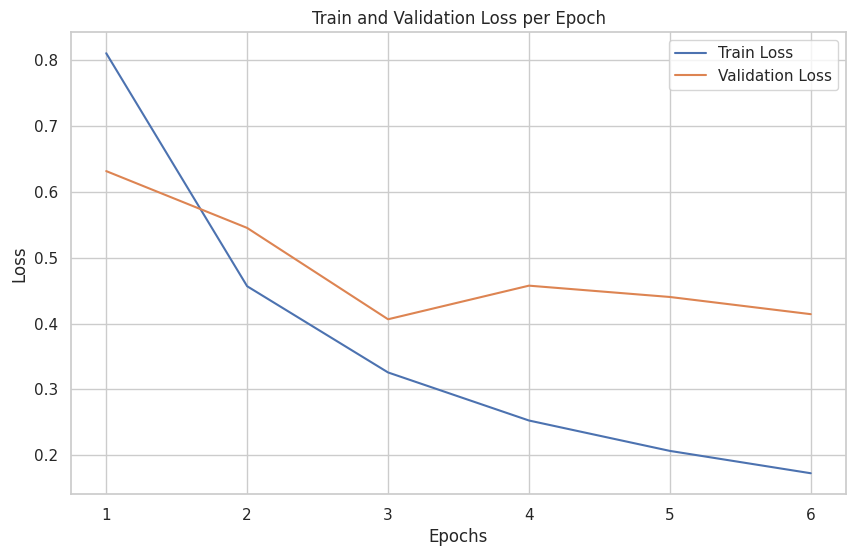

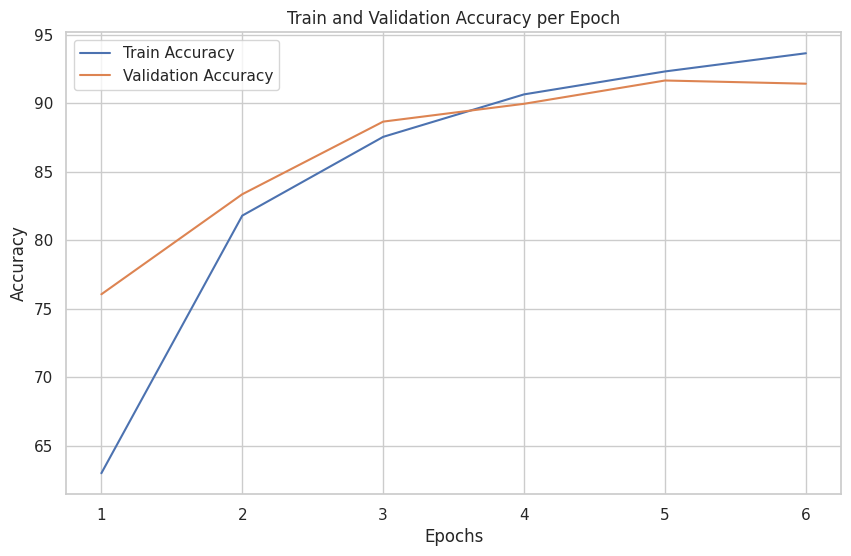

In [61]:
utils.plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies,
                        total_train_loss, total_val_loss, total_train_acc, total_val_acc)

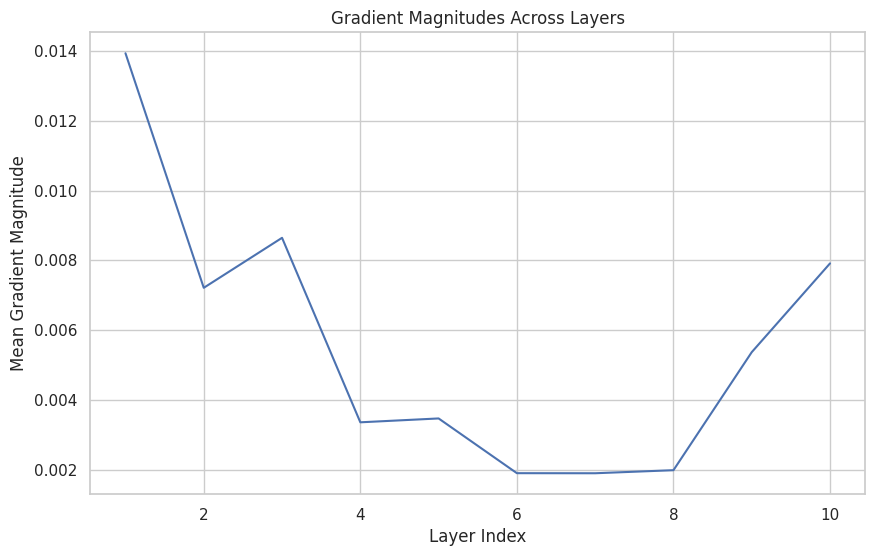

In [62]:
utils.plot_gradient(model)

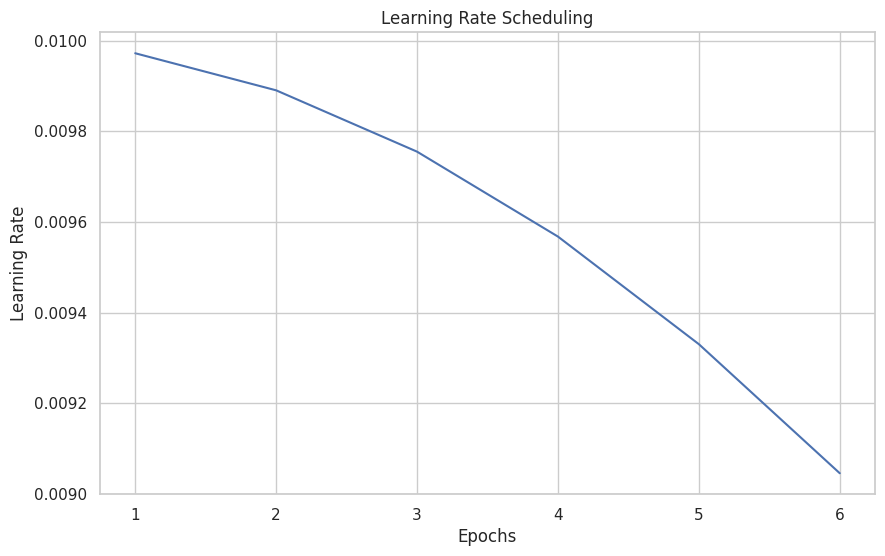

In [63]:
utils.plot_lr_scheduler(lr_history)

In [64]:
all_preds_val, all_labels_val, all_images_A_val, all_images_B_val = utils.inference(model, validation_loader, device)
all_preds_test, all_labels_test, all_images_A_test, all_images_B_test = utils.inference(model, test_loader, device)

257 previsioni errate trovate.


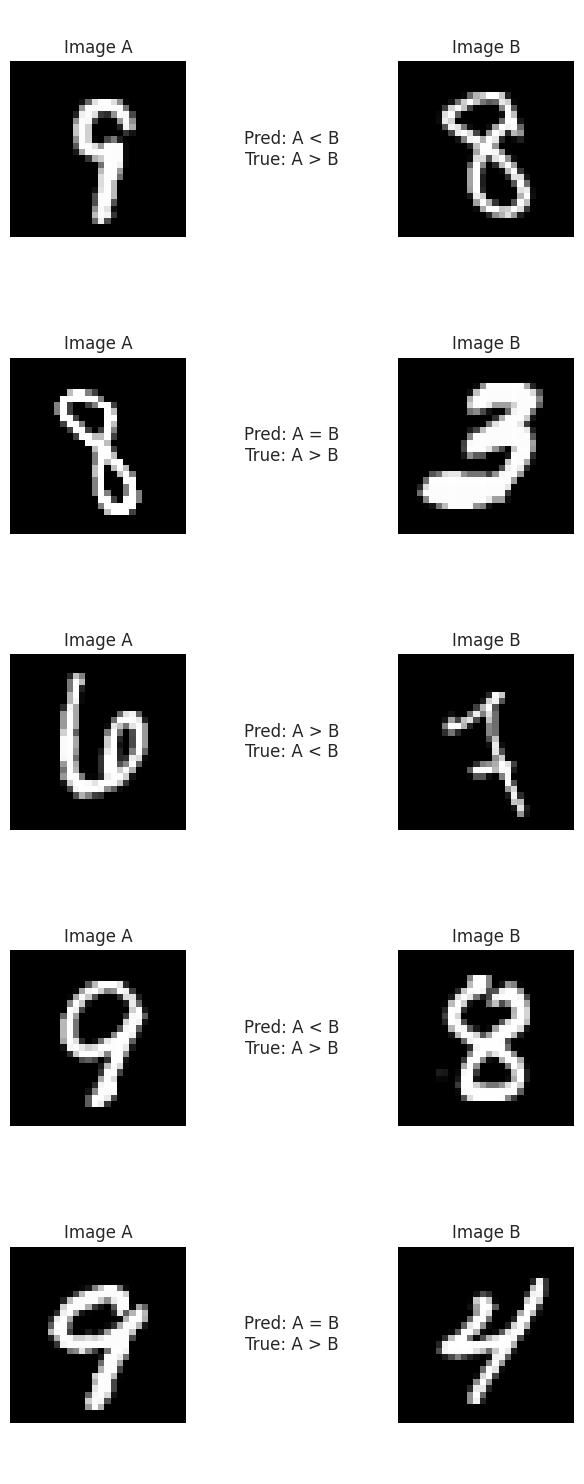

In [65]:
# Visualizza alcune previsioni errate
writer.add_figure('Incorrect_predictions_validation', utils.show_incorrect_predictions(all_preds_val, all_labels_val, all_images_A_val, all_images_B_val, num_images=5))

In [ ]:
# Visualizza alcune previsioni errate
writer.add_figure('Incorrect_predictions_test', utils.show_incorrect_predictions(all_preds_test, all_labels_test, all_images_A_test, all_images_B_test, num_images=5))

540 previsioni errate trovate.


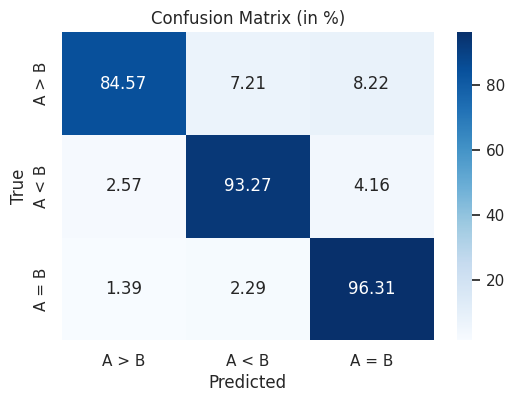

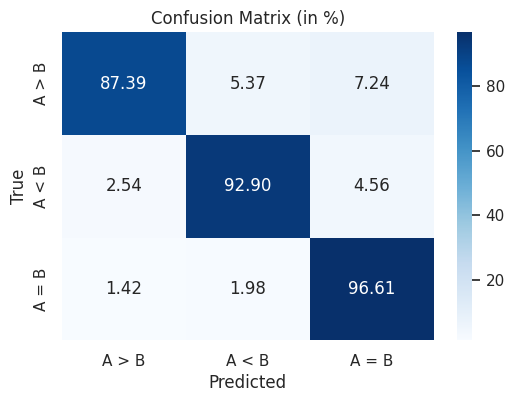

In [ ]:
# Calcola e visualizza la matrice di confusione
writer.add_figure('Confusion_matrix_validation', utils.plot_confusion_matrix(all_preds_val, all_labels_val))
writer.add_figure('Confusion_matrix_test', utils.plot_confusion_matrix(all_preds_test, all_labels_test))
#plot_confusion_matrix(model, test_loader, device)


In [ ]:
# Stampa il report delle metriche
utils.classification_metrics(all_preds_test, all_labels_test)

              precision    recall  f1-score   support

       A > B       0.96      0.87      0.91      2348
       A < B       0.93      0.93      0.93      2323
       A = B       0.89      0.97      0.93      2329

    accuracy                           0.92      7000
   macro avg       0.92      0.92      0.92      7000
weighted avg       0.92      0.92      0.92      7000



Precision: Il numero di veri positivi diviso per il numero di esempi che sono stati predetti come positivi.
Recall (Sensibilità): Il numero di veri positivi diviso per il numero di esempi che appartengono effettivamente alla classe positiva.
F1-Score: La media armonica tra precisione e recall. È utile quando hai un dataset squilibrato.
Support: Il numero di campioni effettivi per ogni classe.

In [ ]:
# Funzione per salvare una copia del notebook
def save_notebook_copy(notebook_name='main.ipynb'):
    # Leggi il notebook attuale
    with open(notebook_name, 'r') as f:
        notebook_content = nbformat.read(f, as_version=4)
    
    if OPTIMIZER == 'SGD':
        new_notebook_name = f"run28x28_BS={BATCH_SIZE}_LR={LEARNING_RATE}_MOM={MOMENTUM}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}.ipynb"
    elif OPTIMIZER == 'ADAM':
        new_notebook_name = f"run28x28_BS={BATCH_SIZE}_LR={LEARNING_RATE}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}.ipynb"
    
    # Salva il notebook con il nuovo nome
    with open(new_notebook_name, 'w') as f:
        nbformat.write(notebook_content, f)
    print(f"Notebook saved as {new_notebook_name}")

# Specifica il nome del notebook attuale
save_notebook_copy('main.ipynb')


Notebook saved as run32x32_BS=128_LR=0.01_MOM=0.9_EPOCHS=20_AUG=False_TRA=False_OPT=SGD.ipynb


In [ ]:
writer.close()